# Examples of Persistence Diagrams

We now understand the full mathematical pipeline for creating a persistence diagram from a dataset:

Dataset $\to$ Filtered Simplicial Complex $\to$ Persistence Module $\to$ Persistence Diagram

 - The first step is accomplished by, for example, assigning a sequence of Vietoris-Rips complexes to point cloud data. 
 - The second step involves computing the $k$th homology vector space of each Vietoris-Rips complex. 
 - Finally, the last step follows from the interval decomposition we get from the Fundamental Theorem of Persistent Homology.
 
In this notebook, we will look at a few more examples of persistence diagrams generated from toy datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from sklearn.metrics import pairwise_distances

import gudhi as gd

## Some 2-Dimensional Datasets

Let's look at a dataset consisting of a pair of circles in the plane. We can parameterize our example by including a variable radius and offset parameter. One circle will always be radius 1, centered at the origin. The other circle will be variable. We can also include variable noise terms.

In [2]:
def create_circle_data(radius, x_offset, noise1 = 0.5, noise2 = 0.5, num_points1 = 50, num_points2 = 50):
    
    A = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = num_points1)
    A = A.T/np.linalg.norm(A,axis = 1)
    A = A.T + noise1*np.random.rand(num_points1,2)

    B = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = num_points2)
    B = radius*B.T/np.linalg.norm(B,axis = 1)
    B = B.T + noise2*np.random.rand(num_points2,2) + [x_offset,0]

    X = np.concatenate((A,B))
    
    return X

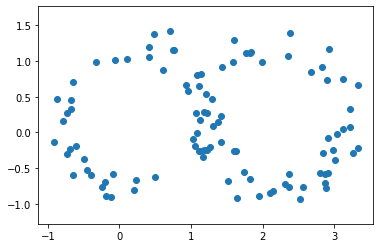

In [3]:
X = create_circle_data(1,2)

plt.plot(X[:,0],X[:,1],'o')
plt.axis('equal')
plt.show()

Last week we introduced the `gudhi` package for computing persistence diagrams. The following function will take a point cloud and produce either barcodes or persistence diagrams.

In [4]:
def visualize_persistent_homology(X, style = 'barcodes', max_dimension = 2):

    """
    In: X is a Euclidean point cloud of size [num_points,dimension]
        style = 'barcodes' or 'diagrams'
        max_dimension = highest dimensional skeleton of the VR complex to compute. Highest degree
        persistent homology will be one less than this.
    Out: plots either persistence barcodes or persistence diagrams
    """
    
    D = pairwise_distances(X)
    skeleton = gd.RipsComplex(distance_matrix = D, max_edge_length = 10) 
    Rips_complex = skeleton.create_simplex_tree(max_dimension = max_dimension)
    BarCodes = Rips_complex.persistence()

    if style == 'barcodes':
        for dim in range(max_dimension):
            print('Dimension',dim)
            plt.figure()
            gd.plot_persistence_barcode([bar for bar in BarCodes if bar[0] == dim])
            plt.show()
    elif style == 'diagrams':
        plt.figure()
        gd.plot_persistence_diagram(BarCodes)
        plt.show()
            
    return

Let's test it:

Dimension 0


<Figure size 432x288 with 0 Axes>

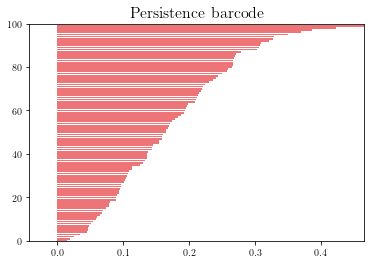

Dimension 1


<Figure size 432x288 with 0 Axes>

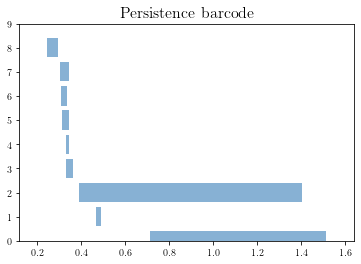

In [5]:
visualize_persistent_homology(X)

<Figure size 432x288 with 0 Axes>

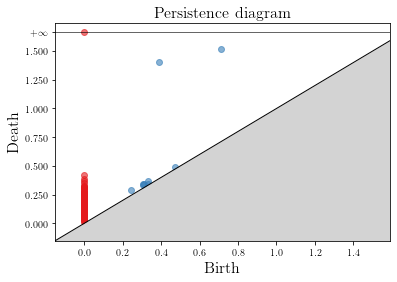

In [6]:
visualize_persistent_homology(X, style = 'diagrams')

Now we can try this on different point clouds and see if the results make sense.

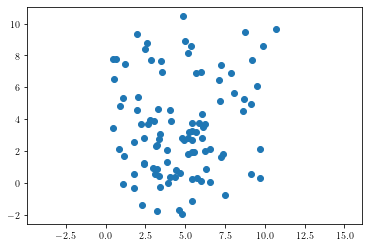

Dimension 0


<Figure size 432x288 with 0 Axes>

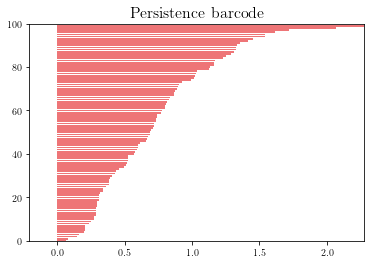

Dimension 1


<Figure size 432x288 with 0 Axes>

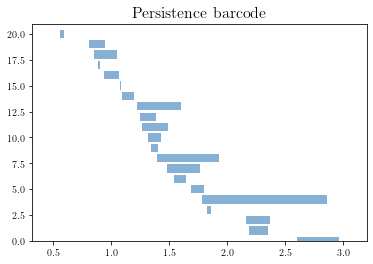

<Figure size 432x288 with 0 Axes>

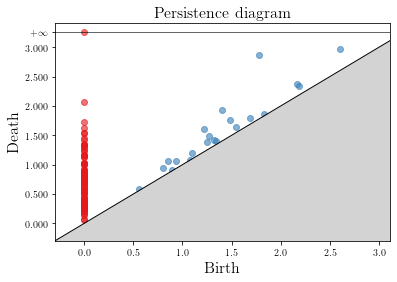

In [7]:
# Pick parameters:
radius = 2
x_offset = 3
noise1 = 10
noise2 = 3
num_points1 = 50
num_points2 = 50

X = create_circle_data(radius,x_offset,noise1 = noise1, noise2 = noise2, num_points1 = num_points1, num_points2 = num_points2)

plt.plot(X[:,0],X[:,1],'o')
plt.axis('equal')
plt.show()

visualize_persistent_homology(X)

visualize_persistent_homology(X, style = 'diagrams')

## 3-Dimensional Datasets

Next we can look at some simple 3-dimensional point clouds. We'll start with a sphere.

In [8]:
# Define a function to sample randomly from a sphere
def sample_spherical(npoints, ndim=3):
    sample = np.random.randn(ndim, npoints)
    sample /= np.linalg.norm(sample, axis=0)
    sample = sample.T
    return sample

# Randomly sample from a sphere with added noise
def noisy_sample_spherical(npoints, ndim, noise_level = 0.01):
    sphere = sample_spherical(npoints, ndim)
    noise = np.random.multivariate_normal(ndim*[0], noise_level*np.eye(ndim), npoints)
    sample = sphere + noise
    return sample

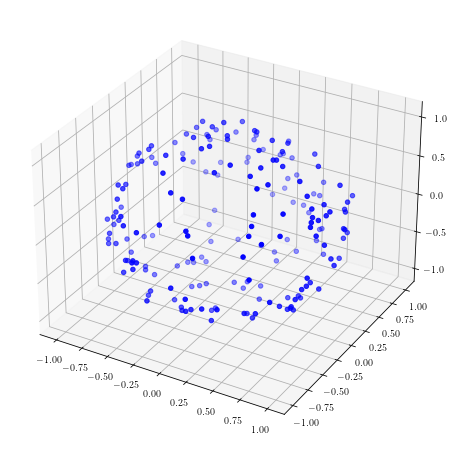

In [9]:
data = noisy_sample_spherical(200,3,noise_level = .001)
# Generate the noisy circle.

# Plot the data as a scatter plot.
fig = plt.figure(figsize = (8,8))
ax = fig.gca(projection='3d', adjustable='box')
ax.scatter(data[:,0],data[:,1],data[:,2], c='b', marker='o');

For this example, we'd like to look at higher dimensional homology. Unfortunately, `gudhi` is a bit slow for computing higher dimensional persistent homology (I believe that it has some ways to sparsify simplicial complexes, which may make it faster). You can try running the function we created above, but it will take quite a while to run.

In [10]:
# visualize_persistent_homology(data, max_dimension=3)

We can instead use a different TDA package which is optimized specifically to handle Vietoris-Rips persistent homology on point clouds. The algorithm is called `ripser`. To install `ripser` as well as the `persim` package (which includes some visualization tools, plus some functions for vectorizing persistence diagrams that we will discuss later), you can install the `scikit-tda` package: see https://scikit-tda.org/index.html. 

**Disclaimer:** I've seen people have trouble installing these packages, in particular on Windows machines.

In [11]:
from ripser import ripser
from persim import plot_diagrams 

`ripser` does the job a lot more quickly, but is still not super fast if we compute higher dimensional persistent homology on large point clouds. You can experiment with parameters here to see how far you can push this.

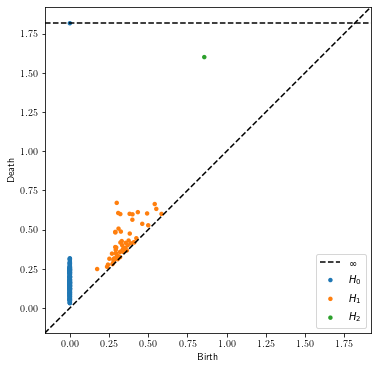

CPU times: user 2.3 s, sys: 208 ms, total: 2.51 s
Wall time: 2.45 s


In [12]:
%%time
dgms = ripser(data, maxdim=2)['dgms']
fig = plt.figure(figsize=(6,6))
plot_diagrams(dgms, show=True)

The following point cloud lies on the surface of a donut in 3-dimensional space (called a *torus*).

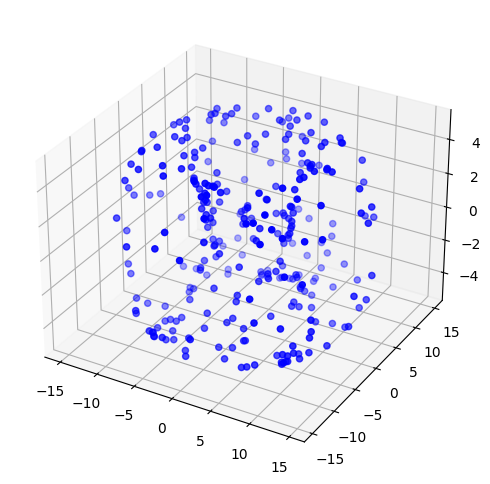

In [13]:
N = 300
r = 5
R = 10

theta = 2*np.pi*np.random.rand(N)
phi = 2*np.pi*np.random.rand(N)
X = (R + r * np.cos(phi)) * np.cos(theta)
Y = (R + r * np.cos(phi)) * np.sin(theta) 
Z = r *  np.sin(phi)
pointCloud = np.append(X.reshape(N,1),Y.reshape(N,1),axis =1)
pointCloud = np.append(pointCloud,Z.reshape(N,1), axis = 1)


fig = plt.figure(figsize = (6,6))
ax = fig.gca(projection='3d', adjustable='box')
ax.scatter(pointCloud[:,0],pointCloud[:,1],pointCloud[:,2], c='b', marker='o');

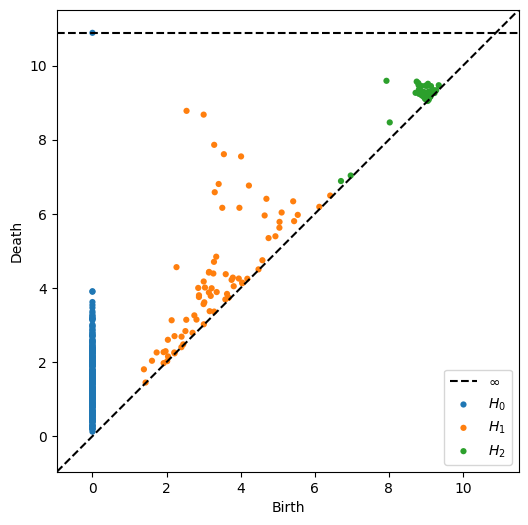

CPU times: user 5.28 s, sys: 398 ms, total: 5.68 s
Wall time: 5.12 s


In [14]:
%%time
dgms = ripser(pointCloud, maxdim=2)['dgms']
fig = plt.figure(figsize=(6,6))
plot_diagrams(dgms, show=True)

When sampling a torus, we need to sample fairly densely to get a strong topological signal.